In [233]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,itertools,math,os,sys,datetime,time

import torch

from keras.models import Model,Sequential
from keras.layers import LSTM,Dense,BatchNormalization,Concatenate,Dropout,Input,Activation

from sklearn.model_selection import train_test_split

import pandas as pd

import seaborn as sns

In [84]:
class GEN():
    '''
    Class to generate time series by the common time series modeling assumptions. Model consists of:
        * Deterministic part y_det(t) = det_c[0]*t + det_c[1]
        * Harmonic part y_freq(t) = SUM_{k=-\infty}^{\infty} c[k]*exp(j*2*pi*f0*t)
        * Random gaussian distortions y_rand(t) = GaussianNormal(m=noise_c[0],sigma=noise_c[1])
    Sum up the parts and y(t) = y_det(t) + y_freq(t) + y_rand(t) yields the time series. The class returns the real and
    imaginary parts seperately as features, and automatically generate a training/test set.
    '''
    def __init__(self,f0,c,det_c,coeff_c,noise_c,timesteps=10,sampling_freq=10000,seed=1):
        rnd.seed(seed)
        self.seed = seed
        self.timesteps = timesteps
        self.sampling_freq = sampling_freq
        self.t = np.arange(0,self.timesteps,1/self.sampling_freq)
        self.f0 = f0
        self.w = 2*np.pi*f0
        self.c = c
        assert len(det_c)==2,'Expected list of length 2 for deterministic coefficients.'
        assert len(coeff_c)==2,'Expected list of length 2 for frequency data coefficients.'
        assert len(noise_c)==2,'Expected list of length 2 for noise coefficients.'
        self.det_m = det_c[0]
        self.det_t = det_c[1]
        self.coeff_mu = coeff_c[0]
        self.coeff_sigma = coeff_c[1]
        self.noise_mu = noise_c[0]
        self.noise_sigma = noise_c[1]
        self.__get_components__()
        self.__get_series__()
        return
    def __get_components__(self):
        self.y_det = (self.det_m*self.t + self.det_t)*(1+1j)
        self.y_freq = sum([self.c[k]*np.exp(1j*self.w*self.t*(k-self.c.shape[0]//2)) for k in range(self.c.shape[0])])
        self.y_rand = (self.noise_sigma*rnd.randn(self.t.shape[0]) + self.noise_mu)*(1+1j)
        return
    def __get_series__(self):
        self.y = self.y_det + self.y_freq + self.y_rand
        return
    def generate_stacked_featureset(self):
        return np.stack([np.real(self.y),np.imag(self.y)],axis=1)
    def generate_set(self,Lin,Lout,Loffset=0):
        yy = self.generate_stacked_featureset()
        X = []
        Y = []
        for k in range(Lin,yy.shape[0]-Loffset-Lout):
            X.append(yy[k-Lin:k])
            Y.append(yy[k+Loffset:k+Loffset+Lout])
        return np.array(X),np.array(Y)

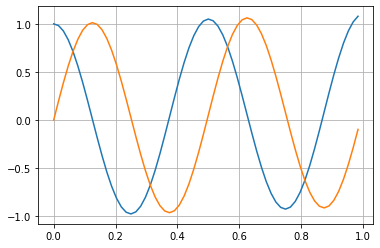

In [126]:
g = GEN(
    f0=2,
    c=np.array([0,0,1]),
    det_c=[0.1,0],
    coeff_c=[0+1j*0,0+1j*0],
    noise_c=[0,0],
    timesteps=1000,
    sampling_freq=64
)

y = g.generate_stacked_featureset()

plt.plot(g.t[:g.sampling_freq],y[:g.sampling_freq])
plt.grid()

plt.show()

In [190]:
X,Y = g.generate_set(
    Lin=25,
    Lout=1,
    Loffset=0
)

In [202]:
XX = X[:,:,1].reshape(-1,25,1)
YY = Y[:,:,1].reshape(-1,1,1)

In [203]:
X0,X1,Y0,Y1 = train_test_split(XX,YY,test_size=0.1,shuffle=True) 

In [216]:
in0 = Input(shape=(25,1,))

x = LSTM(units=16,activation='relu',return_sequences=True)(in0)
x = LSTM(units=8,activation='relu',return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.25)(x)
x = Dense(units=8,activation='relu')(x)
x = Dense(units=8,activation='relu')(x)
x = Dense(units=4,activation='relu')(x)
x = Dense(units=2,activation='relu')(x)
x = Dropout(rate=0.25)(x)

out0 = Dense(units=1,activation='linear')(x)

model = Model(inputs=[in0],outputs=[out0])

model.compile(optimizer='adam',loss='mse',metrics=[])

In [217]:
model.fit(X0,Y0,epochs=15,batch_size=5,validation_split=0.1,shuffle=True)

Epoch 1/15
10364/10364 [==============================] - 81s 8ms/step - loss: 991.2893 - val_loss: 277.7138
Epoch 2/15
10364/10364 [==============================] - 80s 8ms/step - loss: 714.7349 - val_loss: 186.8889
Epoch 3/15
10364/10364 [==============================] - 84s 8ms/step - loss: 560.0632 - val_loss: 150.4627
Epoch 4/15
10364/10364 [==============================] - 86s 8ms/step - loss: 459.3104 - val_loss: 151.2134
Epoch 5/15
10364/10364 [==============================] - 83s 8ms/step - loss: 388.7928 - val_loss: 114.4546
Epoch 6/15
10364/10364 [==============================] - 85s 8ms/step - loss: 339.8159 - val_loss: 86.9028
Epoch 7/15
10364/10364 [==============================] - 83s 8ms/step - loss: 309.0634 - val_loss: 81.7746
Epoch 8/15
10364/10364 [==============================] - 84s 8ms/step - loss: 284.9480 - val_loss: 68.0110
Epoch 9/15
10364/10364 [==============================] - 81s 8ms/step - loss: 270.1266 - val_loss: 68.7539
Epoch 10/15
10364/10364

In [218]:
model.evaluate(X1,Y1)

200/200 [==============================] - 0s 2ms/step - loss: 80.4245


80.42449188232422

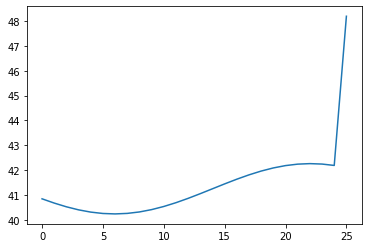

In [220]:
T0 = 0

plt.plot(np.append(X1[T0,:],model.predict(X1[T0,:,:].reshape(-1,25,1))))
plt.show()

In [229]:
df = pd.DataFrame(Y1.reshape(-1,1)).rename(columns={
    0:'Truth'
})

In [231]:
df['Forecast'] = model.predict(X1).reshape(-1,1)

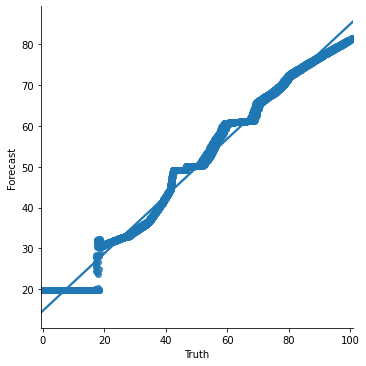

In [234]:
sns.lmplot(x='Truth',y='Forecast',data=df)

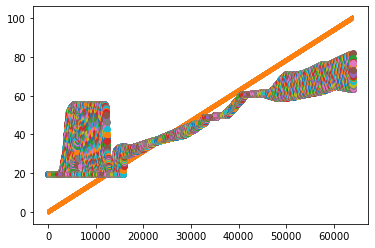

In [268]:
yy = y

plt.plot(yy)

for xc in range(25,yy.shape[0]):
    yc = model.predict(yy[xc-25:xc].reshape(1,-1))
    plt.plot(xc,yc,'o')
    
plt.show()